In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [3]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [4]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [14]:
#choppeddata=pd.read_csv('choppeddata_10_06_2021.csv')#.head()
choppeddata1=pd.read_csv('choppeddata_10_04_2021_equalsuccessfail.csv')#.head()
choppeddata2=pd.read_csv('choppeddata_10_06_2021_equalsuccessfail.csv')#.head()
print(choppeddata1.shape)
print(choppeddata2.shape)
frames = [choppeddata1, choppeddata2]
choppeddata = pd.concat(frames)
print(choppeddata.shape)

(1440, 10)
(3960, 10)
(5400, 10)


In [15]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(5400, 10)
total runs: 900


In [16]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", test_x.size)
print("Train set Y size", train_y.size)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x.size)
print("Test set Y size", test_y.size)

x.shape (900, 5, 10)
Test set X size 11250
Train set Y size 675
Test set X size 11250
Test set Y size 225


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [8]:
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [7]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):

    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

def evaluatefull(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)




x.shape (900, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/3000 Done, Total Loss: 0.2474797921521323   Time Elapsed: 0.04506500000002234 seconds
Epoch 80/3000 Done, Total Loss: 0.23171513988858178   Time Elapsed: 0.045098999999936495 seconds
Epoch 120/3000 Done, Total Loss: 0.20816763313043685   Time Elapsed: 0.04659000000015112 seconds
Epoch 160/3000 Done, Total Loss: 0.19000478727476938   Time Elapsed: 0.04443500000002132 seconds
Epoch 200/3000 Done, Total Loss: 0.1578974269685291   Time Elapsed: 0.04446800000005169 seconds
Epoch 240/3000 Done, Total Loss: 0.13247635783184142   Time Elapsed: 0.04548900000008871 seconds
Epoch 280/3000 Done, Total Loss: 0.12310370412610826   Time Elapsed: 0.04611899999986235 seconds
Epoch 320/3000 Done, Total Loss: 0.11385272248160272   Time Elapsed: 0.044951999999966574 seconds
Epoch 360/3000 Done, Total Loss: 0.11579080351761409   Time Elapsed: 0.04571600000008402 seconds
Epoch 400/3000 Done, Total Loss: 0.09885252834785552   Time Elapsed: 0.04534899999998743 seconds
Epoch 440/3000 Done, Total Loss:

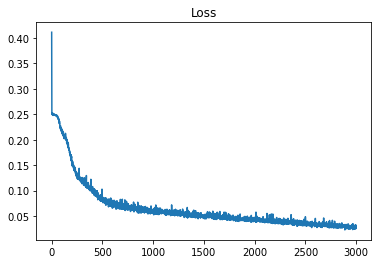

Vs Training Set
Evaluation Time: 0.004442000000153712
sMAPE: 14.226501666634316%
-0.07716861
Vs Test Set
Evaluation Time: 0.0008539999998902204
sMAPE: 16.058104830049913%

 vs training data= 576 / 675  vs test data= 166 / 225 73 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.0016550000000279397
sMAPE: 14.226501666634316%
-0.07716861
Vs Test Set
Evaluation Time: 0.0009600000000773434
sMAPE: 16.058104830049913%

 vs training data= 618 / 675  vs test data= 181 / 225 80 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.0019070000000738219
sMAPE: 14.226501666634316%
-0.07716861
Vs Test Set
Evaluation Time: 0.0006799999998747808
sMAPE: 16.058104830049913%

 vs training data= 638 / 675  vs test data= 192 / 225 85 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.001576999999997497
sMAPE: 14.226501666634316%
-0.07716861
Vs Test Set
Evaluation Time: 0.0009350000000267755
sMAPE: 16.058104830049913%

 vs training data= 656 / 675  vs test data= 197 / 225 87 % at max d

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:126: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


'\n fixed normalization-400 epochs, batch size of 4\n vs training data= 496 / 675  vs test data= 142 / 225 63 % at max difference 0.2\n vs training data= 563 / 675  vs test data= 163 / 225 72 % at max difference 0.3\n vs training data= 608 / 675  vs test data= 173 / 225 76 % at max difference 0.4\n vs training data= 633 / 675  vs test data= 186 / 225 82 % at max difference 0.5\n \n  fixed normalization-600 epochs, batch size of 4\n vs training data= 644 / 675  vs test data= 171 / 225 76 % at max difference 0.2\n vs training data= 662 / 675  vs test data= 178 / 225 79 % at max difference 0.3\n vs training data= 670 / 675  vs test data= 182 / 225 80 % at max difference 0.4\n vs training data= 672 / 675  vs test data= 187 / 225 83 % at max difference 0.5\n \n \nfixed normalization-600 epochs  lr=.0005, batch size of 4\nvs training data= 631 / 675  vs test data= 157 / 225 69 % at max difference 0.2\nvs training data= 653 / 675  vs test data= 172 / 225 76 % at max difference 0.3\nvs trainin

In [126]:
lr = 0.0001
batch_size = 32
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


random_seed=int(time.time())
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=3000, model_type="GRU")
train2 ,test2=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
train3 ,test3=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
train4 ,test4=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
train5 ,test5=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)

"""
 fixed normalization-400 epochs, batch size of 4
 vs training data= 496 / 675  vs test data= 142 / 225 63 % at max difference 0.2
 vs training data= 563 / 675  vs test data= 163 / 225 72 % at max difference 0.3
 vs training data= 608 / 675  vs test data= 173 / 225 76 % at max difference 0.4
 vs training data= 633 / 675  vs test data= 186 / 225 82 % at max difference 0.5
 
  fixed normalization-600 epochs, batch size of 4
 vs training data= 644 / 675  vs test data= 171 / 225 76 % at max difference 0.2
 vs training data= 662 / 675  vs test data= 178 / 225 79 % at max difference 0.3
 vs training data= 670 / 675  vs test data= 182 / 225 80 % at max difference 0.4
 vs training data= 672 / 675  vs test data= 187 / 225 83 % at max difference 0.5
 
 
fixed normalization-600 epochs  lr=.0005, batch size of 4
vs training data= 631 / 675  vs test data= 157 / 225 69 % at max difference 0.2
vs training data= 653 / 675  vs test data= 172 / 225 76 % at max difference 0.3
vs training data= 667 / 675  vs test data= 181 / 225 80 % at max difference 0.4
83 % at max difference 0.5

fixed normalization-800 epochs  lr=.0005, batch size of 4  ---USED FOR MODEL!!
 vs training data= 661 / 675  vs test data= 173 / 225 76 % at max difference 0.2
 vs training data= 671 / 675  vs test data= 188 / 225 83 % at max difference 0.3
 vs training data= 673 / 675  vs test data= 195 / 225 86 % at max difference 0.4
 vs training data= 674 / 675  vs test data= 203 / 225 90 % at max difference 0.5
"""

In [10]:
def evaluate_episode(model, data,  maxdifference=0.2, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

## save model

In [108]:
import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model,"currentmodel_"+todaydate+".pt")
print("model saved")

10_09_2021
model saved


## Test model on new data

In [8]:
#gru_model2 = GRUNet(*args, **kwargs)
    
gru_model3=torch.load('currentmodel_10_09_2021.pt')
gru_model3.eval()
print("loaded")

loaded


In [12]:
print(test_x.shape)
print(test_x[207].shape)
print(test_x[207, 0:5, 0:3].shape)
print(test_x[207, 0:5, 0:8])
#print(test_x[207][0:2])

(225, 5, 10)
(5, 10)
(5, 3)
[[0.23179927 0.20415276 0.24822461 0.22364096 0.17281305 0.21364944
  0.11272373 0.2817601 ]
 [0.44325037 0.43438526 0.4365364  0.43262203 0.4344749  0.43469503
  0.43501208 0.44216044]
 [0.76839343 0.75835933 0.76760313 0.77020106 0.76965972 0.7758573
  0.77990383 0.65231837]
 [0.56490061 0.57038393 0.56801959 0.57162849 0.56754584 0.57064081
  0.56715507 0.56041699]
 [0.27991141 0.26219407 0.27559123 0.26321803 0.22374622 0.25061919
  0.18237939 0.29018857]]


In [17]:




randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
evaluate_episode(gru_model3, exampledata)

print("actual",test_y[randomindex])

index= 129
(1, 5, 10)
actual [1.]


## simlulate a buffer of 10 timesteps entering the classifier over a single episode, and classifying them

In [18]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 51
final partial data
[[[1.         0.52516292 0.52373187 0.52088687 0.52828987 0.47251348
   0.48243939 0.47420131 0.46527225 0.45122745]
  [1.         0.37364973 0.36673008 0.3697842  0.37308227 0.34810449
   0.32191681 0.32229988 0.31964117 0.31970035]
  [1.         0.92479911 0.9252929  0.92556805 0.92330856 0.90005153
   0.92687169 0.91990586 0.91885466 0.92870274]
  [1.         0.64093208 0.64198152 0.64132462 0.63997927 0.65252647
   0.68253095 0.67943734 0.68248191 0.68295169]
  [1.         0.5485735  0.54855289 0.54942708 0.54922666 0.51491017
   0.49141671 0.4926645  0.48613783 0.47392327]]]

full data
[[[0.52516292 0.52373187 0.52088687 0.52828987 0.47251348 0.48243939
   0.47420131 0.46527225 0.45122745 0.44437269]
  [0.37364973 0.36673008 0.3697842  0.37308227 0.34810449 0.32191681
   0.32229988 0.31964117 0.31970035 0.31536126]
  [0.92479911 0.9252929  0.92556805 0.92330856 0.90005153 0.92687169
   0.91990586 0.91885466 0.92870274 0.92735377]
  [0.64093208 0.641981

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [19]:
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021.csv')#.head()
print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

(7200, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


In [20]:


print(originaldata[headers[20:30]].iloc[4039:4044])

      header20  header21  header22  header23  header24  header25  header26  \
4039  0.313334  0.297908  0.300916  0.295691  0.304691  0.297850  0.298842   
4040  0.887794  0.927183  0.923606  0.929387  0.921559  0.932170  0.925471   
4041  0.689476  0.707595  0.706714  0.707579  0.702587  0.708988  0.708745   
4042  0.516504  0.504406  0.494093  0.490169  0.484280  0.477127  0.479447   
4043  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      header27  header28  header29  
4039  0.298431  0.323285       NaN  
4040  0.922702  0.851257       NaN  
4041  0.709223  0.693128       NaN  
4042  0.476531  0.484857       NaN  
4043  0.000000  1.000000       NaN  


In [21]:

#print(originaldata[headers[0:30]].iloc[4039:4044])
#print(originaldata[headers[0:30]].iloc[4039:4044].to_numpy()
classifytest=originaldata[headers[19:29]].iloc[4038:4043].to_numpy()
labelstest=originaldata[headers[19:29]].iloc[4043].to_numpy()
print(classifytest)
classifytest=np.expand_dims(classifytest, axis=0)
print(classifytest.shape)
print(labelstest)

outputfull=evaluate_episode(gru_model3, classifytest)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",labelstest[9])

[[0.54251199 0.52489482 0.52926319 0.5065195  0.49991385 0.49536954
  0.48716645 0.48923134 0.48428939 0.51027604]
 [0.37858933 0.31333356 0.29790778 0.30091579 0.29569087 0.30469148
  0.29785046 0.29884238 0.29843066 0.32328525]
 [0.93041265 0.88779361 0.92718331 0.92360628 0.92938742 0.92155946
  0.9321705  0.92547146 0.92270207 0.85125721]
 [0.63809043 0.68947554 0.70759451 0.70671384 0.70757924 0.7025874
  0.70898769 0.70874526 0.70922296 0.69312779]
 [0.54499817 0.51650444 0.50440577 0.49409301 0.49016859 0.48428045
  0.47712741 0.4794472  0.4765313  0.48485743]]
(1, 5, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

prediction from 10 timesteps 0.9834100008010864 actual 1.0


In [60]:
#originaldata.iloc[4038:4044]
originaldata.iloc[4296:4301]


,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4296,0.504424,0.500139,0.500742,0.495694,0.461680,0.400098,0.441289,0.371587,0.339200,0.303294,...,0.472100,0.441819,0.408748,0.372491,0.359183,0.370252,0.343189,0.322504,0.330108,NaN
4297,0.363354,0.364032,0.367349,0.371040,0.372036,0.369688,0.368842,0.370010,0.366732,0.368606,...,0.413862,0.417086,0.423674,0.419101,0.416949,0.413783,0.417166,0.412497,0.417925,NaN
4298,0.930412,0.932763,0.931514,0.933560,0.922701,0.910744,0.896983,0.892836,0.894070,0.888915,...,0.930602,0.931661,0.937481,0.938890,0.925051,0.938203,0.924349,0.936457,0.842279,NaN
4299,0.637250,0.636472,0.637261,0.635169,0.631924,0.630074,0.632585,0.630057,0.631139,0.626047,...,0.590425,0.588542,0.585577,0.584705,0.582495,0.587356,0.583383,0.583253,0.577616,NaN
4300,0.554277,0.552516,0.553194,0.551201,0.517149,0.464279,0.467176,0.417121,0.380849,0.343090,...,0.456761,0.451242,0.432226,0.402277,0.393436,0.396574,0.378857,0.367604,0.361760,NaN


In [26]:


okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4296:4301].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4301].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")

    
    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    if abs(float(outputfull)-labelstest[9])>0.9:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.11121343076229095 actual 0.0 OK
prediction from timestep 1 - 11  : 0.17657685279846191 actual 0.0 OK
prediction from timestep 2 - 12  : 0.9729794859886169 actual 0.0 X
prediction from timestep 3 - 13  : 0.21964645385742188 actual 0.0 OK
prediction from timestep 4 - 14  : 0.08269598335027695 actual 0.0 OK
prediction from timestep 5 - 15  : 0.8784304857254028 actual 0.0 OK
prediction from timestep 6 - 16  : 0.8029886484146118 actual 0.0 OK
prediction from timestep 7 - 17  : -0.0299718976020813 actual 0.0 OK
prediction from timestep 8 - 18  : -0.1244903951883316 actual 0.0 OK
prediction from timestep 9 - 19  : -0.07602271437644958 actual 0.0 OK
prediction from timestep 10 - 20  : 0.07060535997152328 actual 0.0 OK
prediction from timestep 11 - 21  : 0.06291083991527557 actual 0.0 OK
prediction from timestep 12 - 22  : 0.0043936073780059814 actual 0.0 OK
prediction from timestep 13 - 23  : 0.46655285358428955 actual 0.0 OK
prediction from timestep 14 - 2

In [137]:
print(exampledata.shape)
print(temparray.shape)

(1, 5, 10)
(1, 5, 10)


model output tensor([[1.1806]], device='cuda:0', grad_fn=<AddmmBackward>)
actual [0.]
